<h1>Creazione modello ARIMA sul totale dei dati registrati dall'ISTAT</h1>

<p>Il DataSet utilizzato contiene i dati relativi al totale dei decessi giornalieri rigistrati dall'ISTAT dal <b>1 gennaio 2015 </b> al <b>30 aprile 2020</b>.
    </p>

In [6]:
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    1947 non-null   object
 1   Totale  1947 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.5+ KB


In [8]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1947 non-null   datetime64[ns]
 1   Totale  1947 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 30.5 KB


<h2> Creazione della serie storica </h2>

In [9]:
df=df.set_index('Data')
df = df.groupby(pd.Grouper(freq='M')).sum()
df.head()


,Totale
Data,
2015-01-31,68514
2015-02-28,61031
2015-03-31,60418
2015-04-30,53591
2015-05-31,50678


In [10]:
ts = df.Totale
ts.head()

Data
2015-01-31    68514
2015-02-28    61031
2015-03-31    60418
2015-04-30    53591
2015-05-31    50678
Freq: M, Name: Totale, dtype: int64

<h2>Visualizzazione della serie storica </h2>

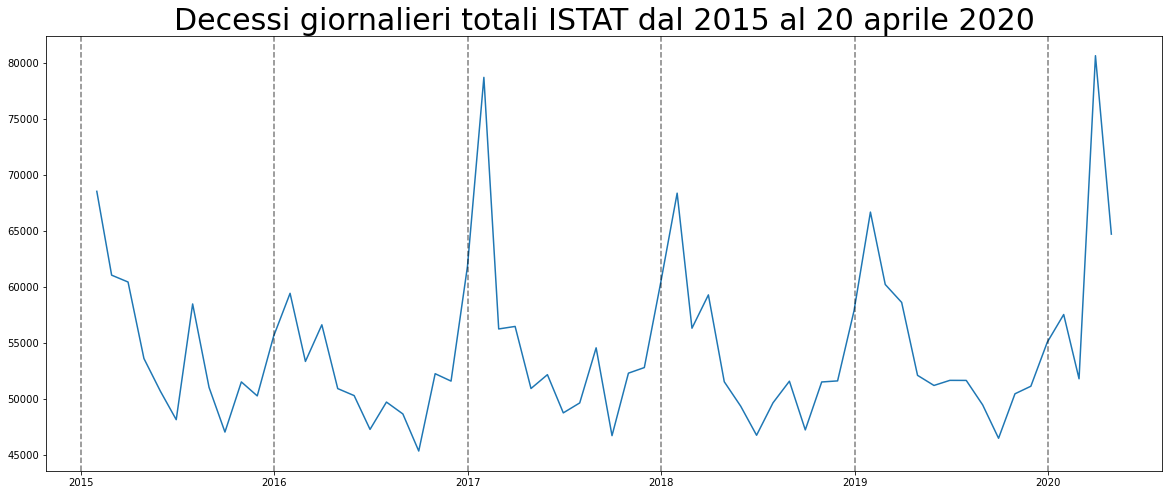

In [11]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.title('Decessi giornalieri totali ISTAT dal 2015 al 20 aprile 2020', size=30)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h2>Decomposizione </h2>

Attraverso la funzione `seasonal_decompose()` la serie storica viene decomposta in <b>trend</b>, <b>stagionalità</b> e <b>residui</b>. 

Tramite questo processo è possibile visionare più nel dettaglio l'andamento della serie storica esaminata, con lo scopo d'impiegare le informazioni acquisite per la creazione di un valido modello predittivo. 


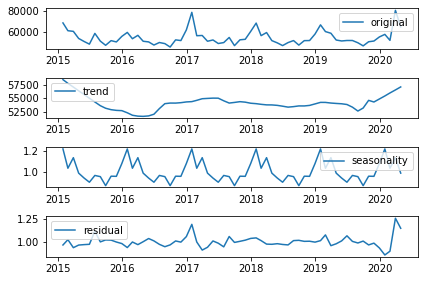

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend 
ts_seasonal = decomposition.seasonal
ts_residual = decomposition.resid
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

Il <b>risultato</b> evince che la serie storica non è stagionale in quanto l'andamento del trendsegue uno schema stagionale.

<h2> Test stazionario </h2>

La modellazione di una serie storica è possibile solo se la serie è <b>stazionaria</b>, ovvero quando le sue proprietà statistiche non variano nel tempo.

La funzione `test_stationarity()` verifica che la serie storica sia stazionaria o meno attraverso il calcolo della <b>Rolling Statistic</b> e del <b>Dickey-Fuller test</b>.

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

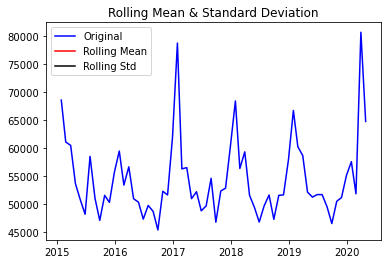

Results of Dickey-Fuller Test:
Test Statistic                 -5.040412
p-value                         0.000018
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64
X is stationary


In [15]:
test_stationarity(ts)

La serie storica risulta essere <b>stazionaria</b>.

In caso contrario, la serie storica sarebbe dovuta essere trasformata tramite un procedimento come il metodo della differenza, di modo che risultasse poi stazionaria.

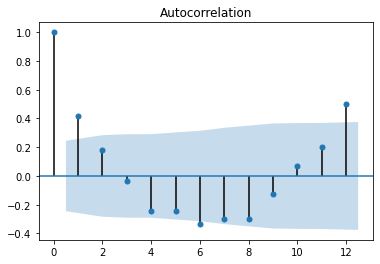

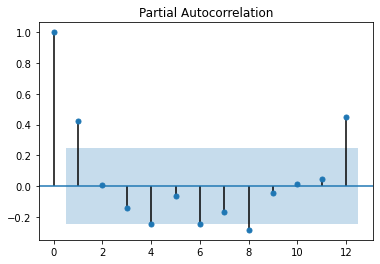

In [16]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

In [17]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

# periodo dal 01-01-2015 al 31-10-2019
train = ts[:train_end]

# periodo dal 01-11-2019 al 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]

#trend COVID: periodo dal 01-01-2020 al 30-04-2020
trend_covid = ts[test_end + timedelta(days=1): covid_end]

In [67]:
#creazione del modello
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
p = 12
q = 8
d = 0
model = SARIMAX(train, order=(p,d,q))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Totale   No. Observations:                   58
Model:              SARIMAX(12, 0, 8)   Log Likelihood                -568.859
Date:                Mon, 02 Nov 2020   AIC                           1179.719
Time:                        14:49:15   BIC                           1222.988
Sample:                    01-31-2015   HQIC                          1196.573
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0932      0.100     -0.933      0.351      -0.289       0.103
ar.L2          0.1556      0.115      1.350      0.177      -0.070       0.382
ar.L3          0.1287      0.122      1.055      0.2

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


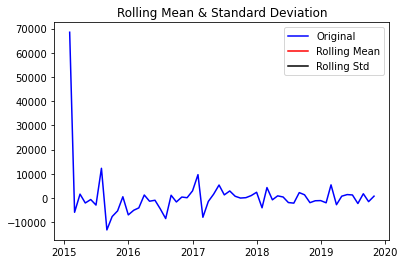

Results of Dickey-Fuller Test:
Test Statistic                -19.809419
p-value                         0.000000
#Lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
X is stationary


In [68]:
#verifico che i residui della serie siano stazionari
residuals = model_fit.resid
test_stationarity(residuals)

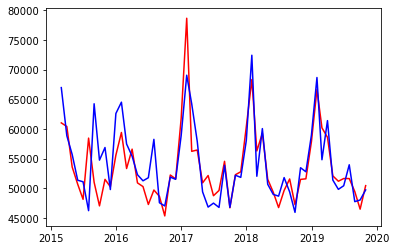

In [69]:
plt.plot (train.iloc[1:], color='red')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue')
plt.show()

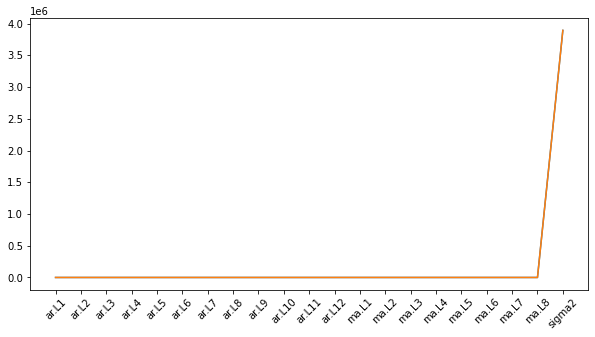

In [70]:
#Intervallo di confidenza del modello
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

In [71]:
#get prediction start and end dates
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-30 00:00:00


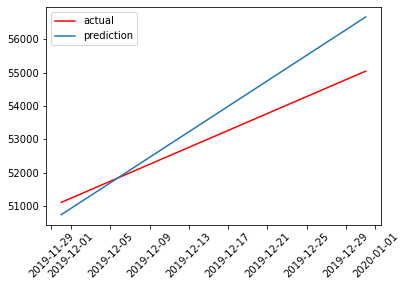

In [72]:
#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [73]:
#calcolo RMSE
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.29915509103845206


In [74]:
#get prediction start and end dates
start = ts.index[0]
end = ts.index[-1]


print(end)
print(start)

2020-04-30 00:00:00
2015-01-31 00:00:00


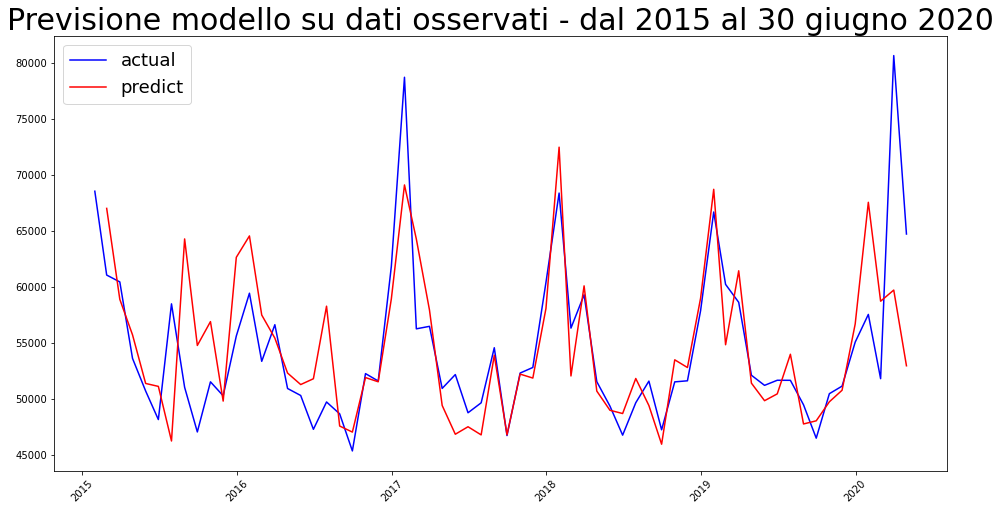

In [75]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

# predizione sul trend della serie storica includendo il 2020
predictions = model_fit.predict(start=start_prediction, end=end_prediction)

predictions_tot = predictions 

plt.figure(figsize=(16,8))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 giugno 2020', size=30)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 18})
plt.show()

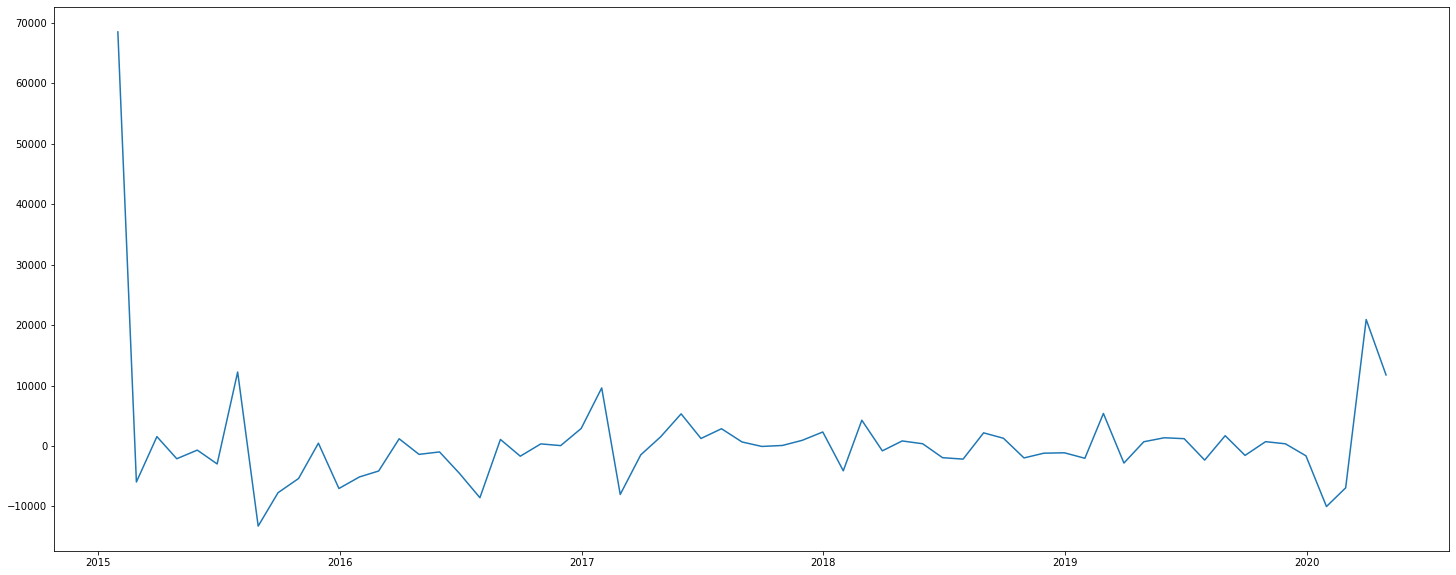

In [76]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(25,10))
plt.plot(diff_predictions_tot)
plt.show()

In [77]:
predictions_tot.to_csv('csv/predictions_daily_SARIMA.csv')

In [78]:
diff_predictions_tot['24-02-2020':].sum()

25776.92767690913

In [79]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(in_c['upper Totale'] - in_c['lower Totale'])

2015-01-31        0.000000
2015-02-28    66982.351388
2015-03-31    58862.413064
2015-04-30    55693.448656
2015-05-31    51353.371040
                  ...     
2019-12-31    56664.915330
2020-01-31    67526.116766
2020-02-29    58695.957364
2020-03-31    59690.887147
2020-04-30    52932.227813
Freq: M, Name: predicted_mean, Length: 64, dtype: float64
            lower Totale  upper Totale
2015-01-31 -99181.151210  99181.151210
2015-02-28  46128.167779  87836.534997
2015-03-31  38094.564682  79630.261446
2015-04-30  36305.266394  75081.630919
2015-05-31  31974.313572  70732.428508
...                  ...           ...
2019-12-31  51852.574608  61477.256052
2020-01-31  62529.495882  72522.737650
2020-02-29  53634.019104  63757.895624
2020-03-31  54627.559865  64754.214429
2020-04-30  47814.083683  58050.371942

[64 rows x 2 columns]
2015-01-31    198362.302420
2015-02-28     41708.367218
2015-03-31     41535.696764
2015-04-30     38776.364526
2015-05-31     38758.114936
              

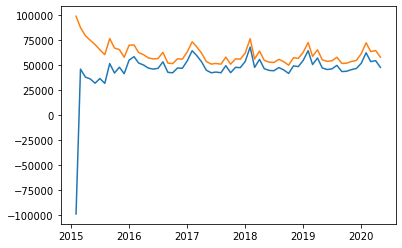

In [80]:
plt.plot(in_c)
plt.show()